In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [75]:
data = pd.read_csv('../data/stock_data_blk.csv')
data['Date'] = pd.to_datetime(data['Date'])
cutoff_date = '2023-09-01'
cutoff_date = pd.to_datetime(cutoff_date)
stock_data = data[data['Date'] <= cutoff_date]
future_data = data[data['Date'] > cutoff_date]

In [76]:
X = stock_data.drop(columns=['Date', 'Adj Close', 'Open']).fillna(method='ffill').fillna(method='bfill')
y = stock_data['Adj Close'].fillna(method='ffill').fillna(method='bfill')

In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [78]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

RandomForestRegressor(random_state=42)

In [79]:
last_row = X_scaled[-1:]
future_days = 10
future_features = np.tile(last_row, (future_days, 1))

# Slightly modify these features to simulate change over time
np.random.seed(42)  # Ensure reproducibility
variation = np.random.normal(0, 0.01, future_features.shape)  # Small changes
future_features += variation

# Predict the 'Adj Close' for the next 10 days
predicted_prices = rf_model.predict(future_features)

predicted_prices

array([682.8146521 , 682.94334229, 682.44371704, 682.0139386 ,
       682.36714355, 682.66929749, 683.22258423, 683.06487976,
       682.18523071, 683.66579956])

In [80]:
actual_prices = future_data['Adj Close'][:10]
dates = future_data['Date'][:10]

In [81]:
data = pd.DataFrame({
    'Date': dates,
    'actual price': actual_prices,
    'predicted price': predicted_prices
})

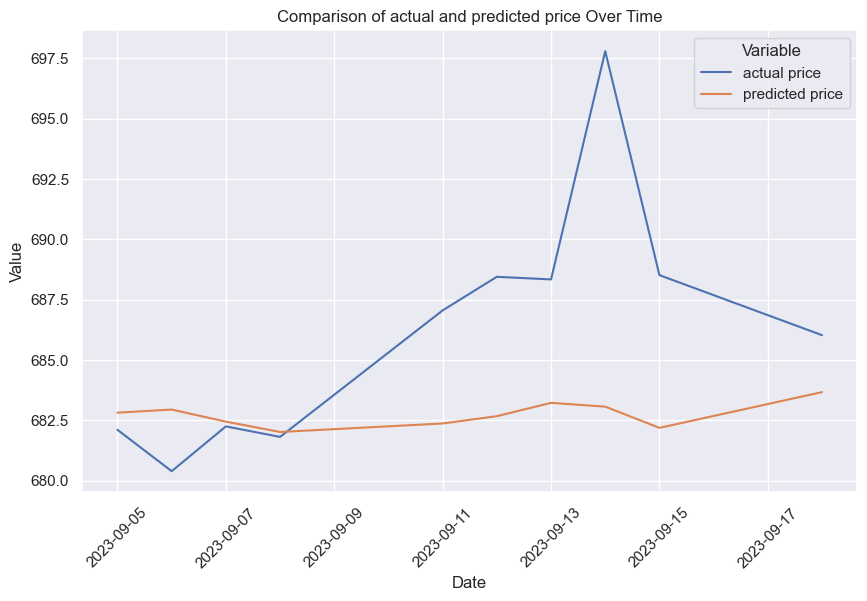

In [82]:
data_long = pd.melt(data, id_vars=['Date'], value_vars=['actual price', 'predicted price'], var_name='Variable', value_name='Value')

# Create the plot
sns.set_theme()  # Set the Seaborn theme
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the data using seaborn lineplot
sns.lineplot(data=data_long, x='Date', y='Value', hue='Variable')

# Customize the plot
plt.title('Comparison of actual and predicted price Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.show()


In [83]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(data['actual price'], data['predicted price']))
print(f'RMSE: {rmse}')

RMSE: 5.926072863305243


In [84]:
import shap
from lime import lime_tabular

In [85]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_scaled,
    feature_names=X.columns,
    class_names=['Adj Close'],
    mode='regression'
)

In [86]:
i = 10  # For example, explain the 10th instance in your dataset
exp = explainer.explain_instance(X_scaled[i], rf_model.predict, num_features=5)
exp.show_in_notebook(show_table=True)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


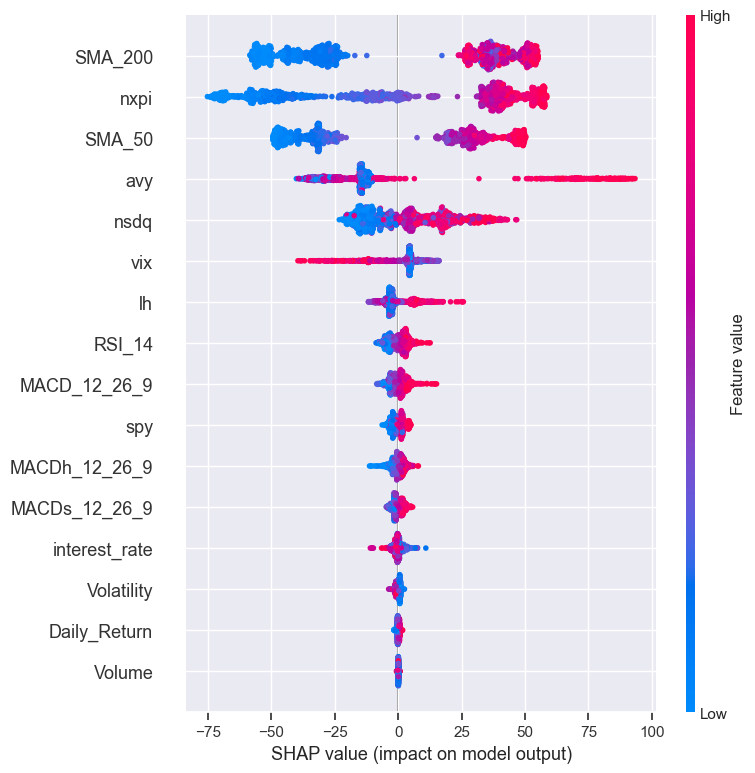

In [87]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_scaled)
shap.summary_plot(shap_values, X_scaled, feature_names=X.columns)